In [1]:
import TSCC
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


Usage of synthetic example dataset

In [2]:
nr_obs = 5000
np.random.seed(0)
# Generate random data
#data = np.random.randn(nr_obs, 4)
# Generate Poisson-distributed random values
data = np.random.poisson(lam=2, size=(nr_obs, 4))
time_index = pd.date_range(start='2023-01-01 00:00', periods=nr_obs, freq='30T')

# Create DataFrame with specified column names
df = pd.DataFrame(data, columns=["ground_truth", "raw", 'fea_1', 'fea_2'], index = time_index)
df["raw"] = abs(df["ground_truth"] + np.random.normal(0, 5, nr_obs)*np.random.randint(0, 2, nr_obs))
df["isError_gt"] = df["ground_truth"] != df["raw"]
df["isError_pred"] = df["isError_gt"]
df

,ground_truth,raw,fea_1,fea_2,isError_gt,isError_pred
2023-01-01 00:00:00,3,3.868966,5,1,True,True
2023-01-01 00:30:00,0,0.000000,7,1,False,False
2023-01-01 01:00:00,3,3.000000,5,2,False,False
2023-01-01 01:30:00,2,6.026272,1,3,True,True
2023-01-01 02:00:00,1,1.000000,1,0,False,False
...,...,...,...,...,...,...
2023-04-15 01:30:00,4,0.819840,4,6,True,True
2023-04-15 02:00:00,6,6.000000,2,1,False,False
2023-04-15 02:30:00,3,5.279944,2,2,True,True
2023-04-15 03:00:00,0,12.759627,2,0,True,True


In [3]:
train, test = train_test_split(df, test_size=0.2)

In [4]:
config = TSCC.assessment.Config(
    colname_target_det="isError_gt", 
    colname_target_corr="ground_truth", 
    colname_raw="raw",
    colname_isErroneousPred="isError_pred",
    exclude_cols = ["isError_gt", "ground_truth"]
)

In [5]:
df_flag_erroneous = config.colname_isErroneousPred
train = train.fillna(-777)
train = train[train[df_flag_erroneous] == True].copy()

In [6]:
train.shape

(2053, 6)

# Plain RF

In [7]:
#default parameters
class_instance = TSCC.correction.ML_byRF()
class_instance.fit(
                train.drop(columns = config.exclude_cols).copy(deep=True),
                train[config.colname_target_corr].copy(deep=True),
                "isError_pred",
                config)
class_instance.predict(
                test.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)

2023-02-11 16:00:00    1.942442
2023-01-22 20:30:00    2.000000
2023-02-08 11:30:00    4.000000
2023-02-04 00:00:00    1.000000
2023-04-07 05:00:00    1.308040
                         ...   
2023-02-24 23:00:00    2.000000
2023-02-12 00:30:00    1.777577
2023-01-29 15:30:00    1.000000
2023-03-16 21:30:00    3.000000
2023-03-28 12:30:00    3.000000
Name: raw_pred, Length: 1000, dtype: float64

# RF with data-level preprocessing/ data augmentation - SMOGN

In [8]:
df_fea, df_tar = TSCC.preprocessing.undersampling_valrange(train.drop(columns = ["ground_truth"]), train[["ground_truth"]], "ground_truth", 0.05, [-1, 0])
train_unders = pd.concat([df_fea, df_tar], axis = 1)

In [9]:
train_unders

,raw,fea_1,fea_2,isError_gt,isError_pred,ground_truth
2023-01-01 01:30:00,6.026272,1,3,True,True,2
2023-01-01 04:30:00,2.365467,1,4,True,True,2
2023-01-01 05:00:00,2.163503,1,2,True,True,5
2023-01-01 05:30:00,4.163708,3,3,True,True,2
2023-01-01 06:30:00,8.640910,2,1,True,True,4
...,...,...,...,...,...,...
2023-04-14 19:30:00,6.404499,6,1,True,True,1
2023-04-14 20:00:00,0.497748,4,1,True,True,2
2023-04-14 20:30:00,0.377937,2,1,True,True,1
2023-04-14 21:00:00,2.683548,5,3,True,True,1


In [10]:
train_smogn_fea, train_smogn_tar = TSCC.preprocessing.SMOGN(train_unders.\
                         drop(columns = config.exclude_cols).\
                         fillna(-777),
                        train_unders[[config.colname_target_corr]],
                        config.colname_target_corr,                   
                        rel_thres = 0.8)

r_index: 100%|########################################################################| 21/21 [00:00<00:00, 777.75it/s]


In [11]:
train_smogn_fea

,raw,fea_1,fea_2,isError_pred
2023-01-01 01:30:00.000,5.428867,1.0,1.0,True
2023-01-01 04:30:00.000,5.461021,1.0,1.0,True
2023-01-01 05:00:00.000,5.112234,1.0,1.0,True
2023-01-01 05:00:00.001,2.163503,1.0,2.0,True
2023-01-01 05:30:00.000,5.669921,1.0,1.0,True
...,...,...,...,...
2023-04-14 13:30:00.000,4.476596,4.0,0.0,True
2023-04-14 15:00:00.000,5.661604,0.0,1.0,True
2023-04-14 16:30:00.000,9.663334,0.0,1.0,True
2023-04-14 19:30:00.000,6.404499,6.0,1.0,True


In [12]:
train_smogn_tar

,ground_truth
2023-01-01 01:30:00.000,7.0
2023-01-01 04:30:00.000,7.0
2023-01-01 05:00:00.000,7.0
2023-01-01 05:00:00.001,5.0
2023-01-01 05:30:00.000,7.0
...,...
2023-04-14 13:30:00.000,3.0
2023-04-14 15:00:00.000,4.0
2023-04-14 16:30:00.000,3.0
2023-04-14 19:30:00.000,1.0


In [13]:
#default parameters
class_instance = TSCC.correction.ML_byRF()
class_instance.fit(
                train_smogn_fea.copy(deep=True),
                train_smogn_tar["ground_truth"].copy(deep=True),
                "isError_pred",
                config,
                preprocessing = "SMOGN"
)
class_instance.predict(
                test.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)

2023-02-11 16:00:00    4.398413
2023-01-22 20:30:00    2.000000
2023-02-08 11:30:00    4.000000
2023-02-04 00:00:00    1.000000
2023-04-07 05:00:00    1.740000
                         ...   
2023-02-24 23:00:00    2.000000
2023-02-12 00:30:00    1.636613
2023-01-29 15:30:00    1.000000
2023-03-16 21:30:00    3.000000
2023-03-28 12:30:00    3.000000
Name: raw_pred, Length: 1000, dtype: float64

# RF with data-level preprocessing/ data augmentation - undersampling

In [14]:
import resreg
relevance = resreg.sigmoid_relevance(train[config.colname_target_corr], 
    cl=None, 
    ch=3 #ch=0.5 in paper (different distribution here, therefore changed the parameter in this example)
    )
X_train, y_train = resreg.random_undersample(
    train.loc[:, ~train.columns.isin(config.exclude_cols)],
    train[config.colname_target_corr], 
    relevance, 
    relevance_threshold = 0.5,
    under='balance', 
    random_state=0)
train_fea_unders = pd.DataFrame(X_train, columns = train.columns[~train.columns.isin(config.exclude_cols)])
train_tar_unders = pd.DataFrame(y_train, columns = [config.colname_target_corr])

(array([280., 566., 544., 357.,   0., 197.,  68.,  26.,  13.,   2.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

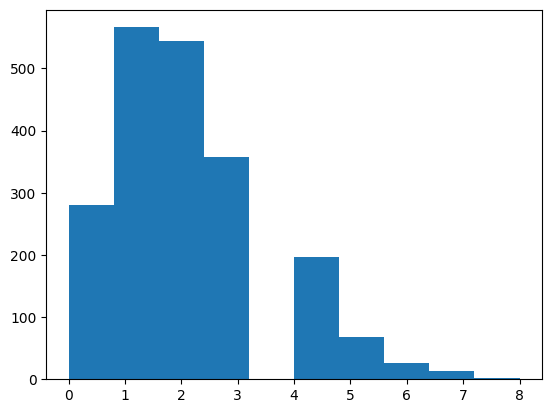

In [15]:
plt.hist(train[config.colname_target_corr])

In [16]:
train_fea_unders

,raw,fea_1,fea_2,isError_pred
0,4.097306,3,0,True
1,1.046155,3,1,True
2,4.633554,0,2,True
3,3.421326,1,0,True
4,5.380745,3,0,True
...,...,...,...,...
607,9.13856,3,2,True
608,3.691234,4,3,True
609,2.561769,1,2,True
610,8.351557,2,3,True


In [17]:
#default parameters
class_instance = TSCC.correction.ML_byRF()
class_instance.fit(
                train_fea_unders.copy(deep=True),
                train_tar_unders.copy(deep=True),
                "isError_pred",
                config)
class_instance.predict(
                test.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)

C:\Users\karen\anaconda3\envs\TSCC_testing\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


2023-02-11 16:00:00    3.094846
2023-01-22 20:30:00    2.000000
2023-02-08 11:30:00    4.000000
2023-02-04 00:00:00    1.000000
2023-04-07 05:00:00    2.452744
                         ...   
2023-02-24 23:00:00    2.000000
2023-02-12 00:30:00    3.159103
2023-01-29 15:30:00    1.000000
2023-03-16 21:30:00    3.000000
2023-03-28 12:30:00    3.000000
Name: raw_pred, Length: 1000, dtype: float64

# RF with model-level adjustments - density weights

This piece of code is computed inside RF fitter with option "density"

In [18]:
from denseweight import DenseWeight
dw = DenseWeight(alpha=1.0)
data_losses_train = dw.fit(train["ground_truth"].to_numpy(dtype="float"))
data_losses_train[0:10]

array([1.44719161e+00, 1.99097532e+00, 1.99097532e+00, 2.57327262e+00,
       2.57327262e+00, 1.44591103e-01, 1.99097532e+00, 3.77762834e+00,
       6.80130866e-04, 1.44591103e-01])

In [19]:
#default parameters
class_instance = TSCC.correction.ML_byRF()
class_instance.fit(
                train.drop(columns = config.exclude_cols).copy(deep=True),
                train[config.colname_target_corr].copy(deep=True),
                "isError_pred",
                None,
                "density")
class_instance.predict(
                test.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)

2023-02-11 16:00:00    1.720356
2023-01-22 20:30:00    2.000000
2023-02-08 11:30:00    4.000000
2023-02-04 00:00:00    1.000000
2023-04-07 05:00:00    1.381053
                         ...   
2023-02-24 23:00:00    2.000000
2023-02-12 00:30:00    1.944351
2023-01-29 15:30:00    1.000000
2023-03-16 21:30:00    3.000000
2023-03-28 12:30:00    3.000000
Name: raw_pred, Length: 1000, dtype: float64

# RF with model-level adjustments - root function

In [20]:
#default parameters
class_instance = TSCC.correction.ML_byRF()
class_instance.fit(
                train.drop(columns = config.exclude_cols).copy(deep=True),
                train[config.colname_target_corr].copy(deep=True),
                "isError_pred",
                None,
                "root")
class_instance.predict(
                test.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)

2023-02-11 16:00:00    2.148536
2023-01-22 20:30:00    2.000000
2023-02-08 11:30:00    4.000000
2023-02-04 00:00:00    1.000000
2023-04-07 05:00:00    1.430361
                         ...   
2023-02-24 23:00:00    2.000000
2023-02-12 00:30:00    1.657497
2023-01-29 15:30:00    1.000000
2023-03-16 21:30:00    3.000000
2023-03-28 12:30:00    3.000000
Name: raw_pred, Length: 1000, dtype: float64

# Evaluation with data-level postprocessing

In [21]:
#default parameters
class_instance = TSCC.correction.ML_byRF()
class_instance.fit(
                train.drop(columns = config.exclude_cols).copy(deep=True),
                train[config.colname_target_corr].copy(deep=True),
                "isError_pred",
                None,
                "root")
train["value_pred"] = class_instance.predict(
                train.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)
test["value_pred"] = class_instance.predict(
                test.drop(columns = config.exclude_cols).copy(deep=True),
                "isError_pred",
                config)

In [22]:
COLUMN_LIST_EVAL_REG = ["ID", "model", "data_set", "cv", "mse", "mse-rel-root", "mse-rel-ind 1.25",
                            "ind1-rel-ind 1.25",
                            "rate-rel-ind 1.25", "rmse", "mae", "nse", "n_obs",
                            "sera"]
df_eval = pd.DataFrame(columns = COLUMN_LIST_EVAL_REG)

In [23]:
cur_row = TSCC.assessment.\
        add_eval_of_model_reg(config, "RF-root_sample_weights", "test", False,
                         test["ground_truth"], test["value_pred"])
df_eval = pd.concat([df_eval, pd.DataFrame([cur_row])], ignore_index=True)


In [24]:
df_eval

,ID,model,data_set,cv,mse,mse-rel-root,mse-rel-ind 1.25,ind1-rel-ind 1.25,rate-rel-ind 1.25,rmse,mae,nse,n_obs,sera
0,raw,RF-root_sample_weights,test,False,1.192372,1.108784,0.888833,0.826159,0.140006,1.091958,0.635118,-0.05,1000,829.641798
